In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.online_portfolio_selection.momentum import *
# import seaborn as sns
import optuna
from mlfinlab.portfolio_optimization import ReturnsEstimators
from mlfinlab.portfolio_optimization import HierarchicalRiskParity
import dl_csv
from mlfinlab.portfolio_optimization.herc import HierarchicalEqualRiskContribution
from mlfinlab.online_portfolio_selection.benchmarks import *
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from pycoingecko import CoinGeckoAPI
from datetime import date, datetime
import ccxt as ccxt

In [277]:
1+1

2

In [128]:
cg = CoinGeckoAPI()
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [143]:
binance_api_key = 'lol'
binance_api_secret = 'hi'

In [261]:
portfolio_coins = ['omisego', 'stellar', '0x', 'ripple', 'tezos', 'loopring', 'binancecoin', 'zcash']

In [262]:
# todays_date = date.today().strftime("%Y-%m-%d")
# from_date = datetime.timestamp(datetime(2020, 1, 1))
# print(from_date)
# datetime.timestamp(date.today())
price_data = cg.get_coin_market_chart_by_id(id=portfolio_coins[-1], vs_currency='btc', days='max')
price_data.keys()
price_data['prices'][-1]


[1594613151000, 0.0067015501177230125]

In [263]:
for i, row in enumerate(price_data['prices']):
    timestamp = row[0]
    price = row[1]
    timestamp = datetime.utcfromtimestamp(timestamp / 1000)
    row[0] = timestamp
    price_data['prices'][i] = row

price_data['prices'][-1]

[datetime.datetime(2020, 7, 13, 4, 5, 51), 0.0067015501177230125]

In [264]:

my_dataframe = []
for i, coin in enumerate(portfolio_coins):
    price_data = cg.get_coin_market_chart_by_id(id=coin, vs_currency='btc', days='max')
    for pdi, row in enumerate(price_data['prices']):
        timestamp = row[0]
        price = row[1]
        timestamp = datetime.utcfromtimestamp(timestamp / 1000)
        row[0] = timestamp
        price_data['prices'][pdi] = row
    current_dataframe = pd.DataFrame.from_records(price_data['prices'], columns=['timestamp', coin])
    current_dataframe.reset_index(drop=True, inplace=True)
    my_dataframe.append(current_dataframe)

my_dataframe[-1].tail()

,timestamp,zcash
1349,2020-07-09 00:00:00,0.006134
1350,2020-07-10 00:00:00,0.006148
1351,2020-07-11 00:00:00,0.006020
1352,2020-07-12 00:00:00,0.006037
1353,2020-07-13 04:05:51,0.006702


In [265]:
portfolio_dataframe = my_dataframe[0]
for i, mdf in enumerate(my_dataframe):
    if (i) == 0: continue
    portfolio_dataframe = pd.merge(portfolio_dataframe, mdf, how='inner', on=['timestamp'])

portfolio_dataframe.set_index('timestamp', inplace=True, drop=True)
portfolio_dataframe.index = pd.to_datetime(portfolio_dataframe.index)
portfolio_dataframe.head()

# Up portfolio
portfolio_dataframe = portfolio_dataframe['2019-12-01': datetime.now().strftime('%Y-%m-%d')]

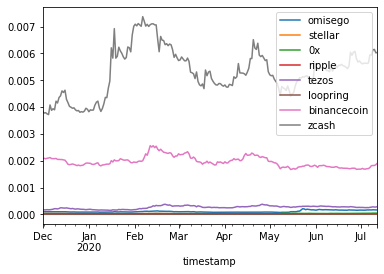

In [120]:

portfolio_dataframe.plot()

In [279]:
study = optuna.create_study(study_name="eg", storage='sqlite:///example.db', direction='maximize')


[I 2020-07-13 14:19:31,510] A new study created with name: eg


In [278]:
study = optuna.delete_study(study_name="eg", storage='sqlite:///example.db')

In [97]:
study = optuna.load_study(study_name="eg", storage='sqlite:///example.db')

In [280]:
def obj(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 2)

    # Multiplicative update
    temp = EG('MU', eta)
    temp.allocate(portfolio_dataframe, verbose=True)

    data_len, period = portfolio_dataframe.shape[0], 10
    for i in range(0, period):
        time = data_len * i // period
        trial.report(temp.portfolio_return.iloc[time][0], step=time)

    return temp.portfolio_return.iloc[-1][0]

In [281]:
number = 10
study.optimize(obj, n_trials=number)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 14:19:35,570] Finished trial#0 with value: 1.583557741816621 with parameters: {'eta': 0.02914242507829004}. Best is trial#0 with value: 1.583557741816621.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 14:19:36,414] Finished trial#1 with value: 1.5844414724550122 with parameters: {'eta': 0.012172914696050944}. Best is trial#1 with value: 1.5844414724550122.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 14:19:37,209] Finished trial#2 with value: 1.5844569891997082 with parameters: {'eta': 0.011872351272972115}. Best is trial#2 with value: 1.5844569891997082.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 14:19:38,015] Finished trial#3 with value: 1.584994642448391 with parameters: {'eta': 0.0014005994376980785}. Best is trial#3 with value: 1.584994642448391.


In [282]:
# study_df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
print("Best parameter: ", study.best_params['eta'])
print("Best returns: ", study.best_trial.value)
print("Best trial number: ", study.best_trial.number)

Best parameter:0.0014005994376980785
Best returns:1.584994642448391
Best trial number:3


In [283]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(title_text="EG ETA between 0 and 2", yaxis_title_text="Relative Returns")
fig.show()

In [284]:
mu = EG(update_rule='MU', eta=study.best_params['eta'])
# mu = EG(update_rule='MU', eta=3)
mu.allocate(asset_prices=portfolio_dataframe, verbose=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [285]:
mu.all_weights.tail(1)

,omisego,stellar,0x,ripple,tezos,loopring,binancecoin,zcash
timestamp,,,,,,,,
2020-07-12,0.125041,0.124976,0.125002,0.124876,0.125028,0.125134,0.124913,0.125028


In [268]:
current_optimised_weightings = mu.all_weights.tail(1).to_dict('records')
print(current_optimised_weightings)

[{'omisego': 0.12851430950395515, 'stellar': 0.12274444062073216, '0x': 0.12506209372872476, 'ripple': 0.11433645744006321, 'tezos': 0.12735491016835623, 'loopring': 0.13722760621847668, 'binancecoin': 0.11740583114507672, 'zcash': 0.12735435117461522}]


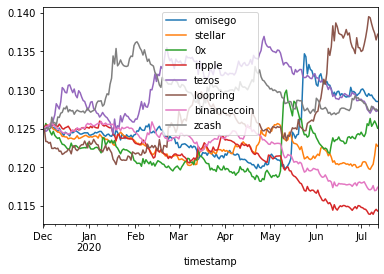

In [269]:
mu.all_weights.plot()

In [270]:
mu.portfolio_return['Returns'].tail()

timestamp
2020-07-08    1.457296
2020-07-09    1.534566
2020-07-10    1.528080
2020-07-11    1.514929
2020-07-12    1.578337
Name: Returns, dtype: float64

In [271]:
fig = go.Figure()
idx = mu.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=mu.portfolio_return['Returns'], name="EG"))
fig.update_layout(title='Momentum Strategy on Crypto', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

In [272]:
mu.weights

array([0.12781176, 0.12311511, 0.1254417 , 0.11402641, 0.12770186,
       0.13791838, 0.11722307, 0.1267617 ])

In [273]:
mu.relative_return[-1]

array([0.99589112, 1.06723215, 1.06736242, 1.01911712, 1.06475788,
       1.08407398, 1.02883581, 1.00275321])

In [274]:
mu.asset_prices.tail()

,omisego,stellar,0x,ripple,tezos,loopring,binancecoin,zcash
timestamp,,,,,,,,
2020-07-08,0.000165,0.000008,0.000044,0.000020,0.000271,0.000010,0.001813,0.005934
2020-07-09,0.000172,0.000009,0.000048,0.000022,0.000281,0.000011,0.001823,0.006134
2020-07-10,0.000168,0.000010,0.000046,0.000022,0.000274,0.000010,0.001821,0.006148
2020-07-11,0.000166,0.000010,0.000044,0.000021,0.000274,0.000010,0.001854,0.006020
2020-07-12,0.000166,0.000010,0.000047,0.000022,0.000291,0.000011,0.001908,0.006037


Progress: |██████████████████████████████████████████████████| 100.0% Complete
timestamp
2020-07-12    1.509406
Freq: W-SUN, Name: Returns, dtype: float64


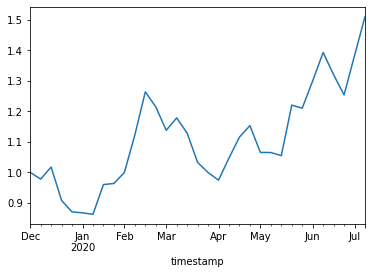

In [275]:
bah = BAH()
bah.allocate(asset_prices=portfolio_dataframe, resample_by='W', verbose=True)
print(bah.portfolio_return['Returns'].tail(1))
bah.portfolio_return['Returns'].plot()

In [144]:
exchange = ccxt.binance({
    "apiKey": binance_api_key,
    "secret": binance_api_secret,
    'enableRateLimit': True,
})

In [370]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print(current_owned_coins)

[{'BTC': 3.682e-05}, {'BNB': 3.15510845}, {'ZRX': 153.807}, {'OMG': 41.62705}, {'LRC': 500.566}, {'ZEC': 1.026853}, {'XRP': 284.38}, {'XLM': 651.92}, {'VTHO': 42.05468331}, {'XTZ': 20.86044}]


In [371]:
current_optimised_weightings[0]

{'omisego': 0.12851430950395515,
 'stellar': 0.12274444062073216,
 '0x': 0.12506209372872476,
 'ripple': 0.11433645744006321,
 'tezos': 0.12735491016835623,
 'loopring': 0.13722760621847668,
 'binancecoin': 0.11740583114507672,
 'zcash': 0.12735435117461522}

In [368]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print(current_owned_coins)
orders = []
for (i, coin_data) in enumerate(current_owned_coins):
    for coin in coin_data:
        # print(coin_data)
        # coin
        if coin == 'BTC':
            continue
        if coin == 'VTHO':
            continue
        amount = coin_data[coin]
        converted = float(amount)
        symbol = coin + '/BTC'
        side = 'sell'
        try:
            result = exchange.create_market_order(symbol, side, converted)
            print('SOLD ' + coin + '\n ')
        except ccxt.InsufficientFunds as e:
            print(coin)
            print(amount)
            print('create_order() failed – not enough funds')
            print(e)
        except ccxt.InvalidOrder as e:
            print(coin)
            print(amount)
            print('invalid_order() failed')
            print(e)
            continue
        except Exception as e:
            print(coin)
            print(amount)
            print('create_order() failed')
            print(e)

[{'BTC': 4.041e-05}, {'BNB': 3.42746026}, {'ZRX': 139.96}, {'OMG': 39.86871}, {'LRC': 432.054}, {'ZEC': 1.037853}, {'XRP': 317.664}, {'XLM': 665.572}, {'VTHO': 42.05468331}, {'XTZ': 22.50132}]
SOLD BNB

SOLD ZRX

SOLD OMG

SOLD LRC

SOLD ZEC

SOLD XRP

SOLD XLM

SOLD XTZ



In [369]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print('Current owned coins ')
print(current_owned_coins)

btc_balance = current_balances['BTC']['free']
exchange.load_markets()
for (coin, weighting) in current_optimised_weightings[0].items():
    try:
        print('COIN ' + coin)
        print('Weighting ' + str(weighting))
        coin_btc_amount_to_buy = (weighting * btc_balance)
        print('BTC AMOUNT TO BUY ' + str(coin_btc_amount_to_buy))
        ticker = cg.get_coin_ticker_by_id(id=coin, exchange_ids=['binance'])
        ticker = ticker['tickers'][0]['base']
        print(ticker)
        symbol = ticker + '/BTC'
        side = 'buy'
        amount_to_buy = (coin_btc_amount_to_buy / exchange.fetchTicker(symbol).get('last'))
        print('BUYING AMOUNT ' + str(amount_to_buy))
        result = exchange.create_market_order(symbol, side, amount_to_buy)
        print('BOUGHT ' + coin + '\n')
    except ccxt.InsufficientFunds as e:
        print(coin)
        print(amount)
        print('bought() failed – not enough funds')
        try: 
            print('TRYING TO BUY AGAIN  ' + coin + '\n')
            result = exchange.create_market_order(symbol, side, amount * 0.95)
            print(e)
        except Exception as e:
            print(coin)
            print(amount)
            print('bought again() failed')
    except Exception as e:
        print(coin)
        print(amount)
        print('fetch() failed')
        print(e)

Current owned coins
[{'BTC': 0.05444053}, {'BNB': 0.00012845}, {'ZRX': 0.96}, {'OMG': 0.00871}, {'LRC': 0.054}, {'ZEC': 0.000853}, {'XRP': 0.664}, {'XLM': 0.572}, {'VTHO': 42.05468331}, {'XTZ': 0.00132}]
COIN omisego
Weighting 0.12851430950395515
BTC AMOUNT TO BUY 0.006996387121979355
OMG
BUYING AMOUNT 41.66996499094316
BOUGHT omisego

COIN stellar
Weighting 0.12274444062073216
BTC AMOUNT TO BUY 0.006682272401946188
XLM
BUYING AMOUNT 652.5656642525573
BOUGHT stellar

COIN 0x
Weighting 0.12506209372872476
BTC AMOUNT TO BUY 0.006808446665501453
ZRX
BUYING AMOUNT 153.8284379914472
BOUGHT 0x

COIN ripple
Weighting 0.11433645744006321
BTC AMOUNT TO BUY 0.0062245373413594846
XRP
BUYING AMOUNT 284.2254493771454
BOUGHT ripple

COIN tezos
Weighting 0.12735491016835623
BTC AMOUNT TO BUY 0.006933268807667703
XTZ
BUYING AMOUNT 20.883339782131635
BOUGHT tezos

COIN loopring
Weighting 0.13722760621847668
BTC AMOUNT TO BUY 0.007470743613165166
LRC
BUYING AMOUNT 501.7289196215693
BOUGHT loopring

COIN